In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

import tensorflow as tf
from tensorflow.keras import layers, models

In [30]:
train = pd.read_csv("UNSW_NB15_training-set.csv")
test = pd.read_csv("UNSW_NB15_testing-set.csv")

In [ ]:
train.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [ ]:
train.shape

(82332, 45)

In [ ]:
test.shape

(175341, 45)

- Select Zero-Day Attack Category

In [31]:
zero_day_class = "Reconnaissance"

zero_day_samples = train[train["attack_cat"] == zero_day_class]
train_known = train[train["attack_cat"] != zero_day_class]
test_known = test[test["attack_cat"] != zero_day_class]
test_zero_day = test[test["attack_cat"] == zero_day_class]

In [ ]:
train_known.shape

(78836, 45)

In [ ]:
test_known.shape

(164850, 45)

In [ ]:
test_zero_day.shape

(10491, 45)

In [ ]:
zero_day_samples = zero_day_samples.drop("id", axis=1)

In [ ]:
zero_day_samples.shape

(3496, 44)

In [ ]:
# Encode categorical features
from sklearn.preprocessing import LabelEncoder

cat_cols = ['proto', 'service', 'state']
encoder = LabelEncoder()

for col in cat_cols:
  train_known[col] = encoder.fit_transform(train_known[col].astype(str))
  test_known[col] = encoder.fit_transform(test_known[col].astype(str))
  test_zero_day[col] = encoder.fit_transform(test_zero_day[col].astype(str))

/tmp/ipython-input-4124474491.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_known[col] = encoder.fit_transform(train_known[col].astype(str))
/tmp/ipython-input-4124474491.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_known[col] = encoder.fit_transform(test_known[col].astype(str))
/tmp/ipython-input-4124474491.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

- Split dataset into X and y

In [ ]:
from re import X
def split_xy(df):
  X = df.drop(["id", "attack_cat", "label"], axis=1)
  y = df["label"]
  return X, y

X_train_known, y_train_known = split_xy(train_known)
X_test_known, y_test_known = split_xy(test_known)
X_test_zero_day, y_test_zero_day = split_xy(test_zero_day)

In [ ]:
X_train_known.shape

(78836, 42)

In [ ]:
X_test_known.shape

(164850, 42)

In [ ]:
X_test_zero_day.shape

(10491, 42)

- Extract only normal data for Autoencoder

In [ ]:
X_train_normal = X_train_known[y_train_known == 0]
X_train_normal.shape

(37000, 42)

- Scale the train_normal, test_known, test_zero_day data using MinMax Scaler

In [ ]:
scaler = StandardScaler()
X_train_normal_scaled = scaler.fit_transform(X_train_normal)
X_test_known_scaled = scaler.transform(X_test_known)
X_test_zero_day_scaled = scaler.transform(X_test_zero_day)

In [ ]:
# Save scaled data for future use

import joblib
joblib.dump(X_train_normal_scaled, "X_train_normal_scaled.pkl")
joblib.dump(X_test_known_scaled, "X_test_known_scaled.pkl")
joblib.dump(X_test_zero_day_scaled, "X_test_zero_day_scaled.pkl")

['X_test_zero_day_scaled.pkl']

In [32]:
# Load the data
import joblib
X_train_normal_scaled = joblib.load("X_train_normal_scaled.pkl")
X_test_known_scaled = joblib.load("X_test_known_scaled.pkl")
X_test_zero_day_scaled = joblib.load("X_test_zero_day_scaled.pkl")

### Building Autoencoder

In [33]:
input_dim = X_train_normal_scaled.shape[1]
encoding_dim = 16

autoencoder = models.Sequential([
    layers.Dense(32, activation='relu', input_shape=(input_dim,)),
    layers.Dense(16, activation='relu'),
    layers.Dense(encoding_dim, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(input_dim, activation='linear')
])

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 32)             │         1,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 42)             │         1,386 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,378 (17.10 KB)

 Trainable params: 4,378 (17.10 KB)

 Non-trainable params: 0 (0.00 B)

- Training Autoencoder

In [34]:
history = autoencoder.fit(
    X_train_normal_scaled,
    X_train_normal_scaled,
    epochs=25,
    batch_size=256,
    shuffle=True,
    validation_split=0.1,
    verbose=1
)

Epoch 1/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.8563 - val_loss: 0.8857
Epoch 2/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4233 - val_loss: 0.5923
Epoch 3/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2421 - val_loss: 0.4701
Epoch 4/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1860 - val_loss: 0.4217
Epoch 5/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1579 - val_loss: 0.3995
Epoch 6/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1444 - val_loss: 0.3857
Epoch 7/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1342 - val_loss: 0.3639
Epoch 8/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1241 - val_loss: 0.3588
Epoch 9/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1124 - val_loss: 0.3532
Epoch 10/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1069 - val_loss: 0.3442
Epoch 11/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1022 - val_loss: 0.3390
Epoch 12/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

- Computing reconstruction error

In [35]:
def reconstruction_errors(model, data):
    reconstructed = model.predict(data, verbose=0)
    errors = np.mean(np.square(data - reconstructed), axis=1)
    return errors

recon_known = reconstruction_errors(autoencoder, X_test_known_scaled)
recon_zero = reconstruction_errors(autoencoder, X_test_zero_day_scaled)

### Autoencoder Reconstruction Error Visualization

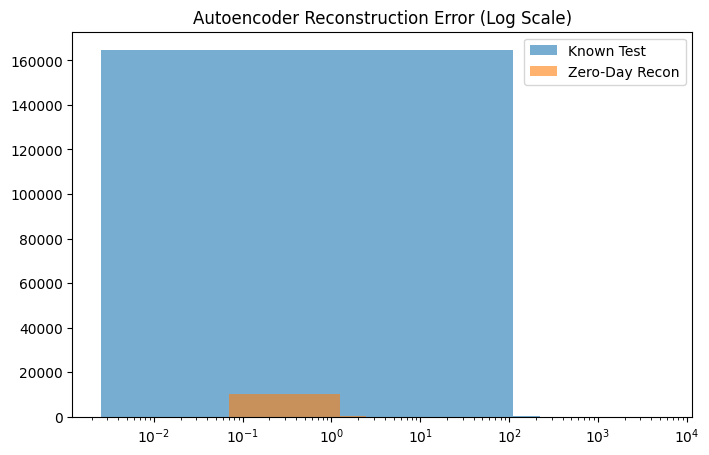

In [36]:
plt.figure(figsize=(8,5))
plt.hist(recon_known, bins=50, alpha=0.6, label="Known Test")
plt.hist(recon_zero,  bins=50, alpha=0.6, label="Zero-Day Recon")
plt.xscale('log')
plt.title("Autoencoder Reconstruction Error (Log Scale)")
plt.legend()
plt.show()


### Training IF

In [37]:
iso = IsolationForest(n_estimators=200, contamination=0.01, random_state=42)
iso.fit(X_train_normal_scaled)

iso_known = iso.decision_function(X_test_known_scaled)
iso_zero = iso.decision_function(X_test_zero_day_scaled)

- IF Score Visualization

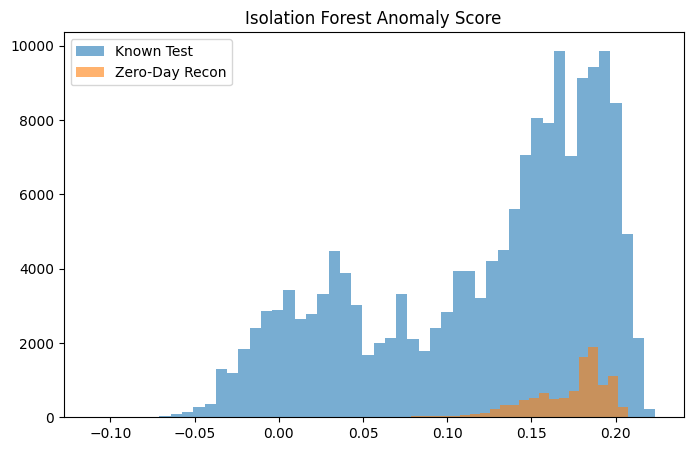

In [38]:
plt.figure(figsize=(8,5))
plt.hist(iso_known, bins=50, alpha=0.6, label="Known Test")
plt.hist(iso_zero, bins=50, alpha=0.6, label="Zero-Day Recon")
plt.legend()
plt.title("Isolation Forest Anomaly Score")
plt.show()

In [39]:
# Normalize and Create hybrid scores

sc = StandardScaler()

# Normalize Reconstruction Error
recon_norm = sc.fit_transform(np.concatenate([recon_known, recon_zero]).reshape(-1, 1))
recon_known_norm = recon_norm[:len(recon_known)].flatten()
recon_zero_norm = recon_norm[len(recon_known):].flatten()

# Normalize IF scores
iso_norm = sc.fit_transform(np.concatenate([iso_known, iso_zero]).reshape(-1, 1))
iso_known_norm = iso_norm[:len(iso_known)].flatten()
iso_zero_norm = iso_norm[len(iso_known):].flatten()

### Hybrid Anomaly Score


In [40]:
hybrid_known = (recon_known_norm + iso_known_norm) / 2
hybrid_zero = (recon_zero_norm + iso_zero_norm) / 2

- Hybrid Score Visualization

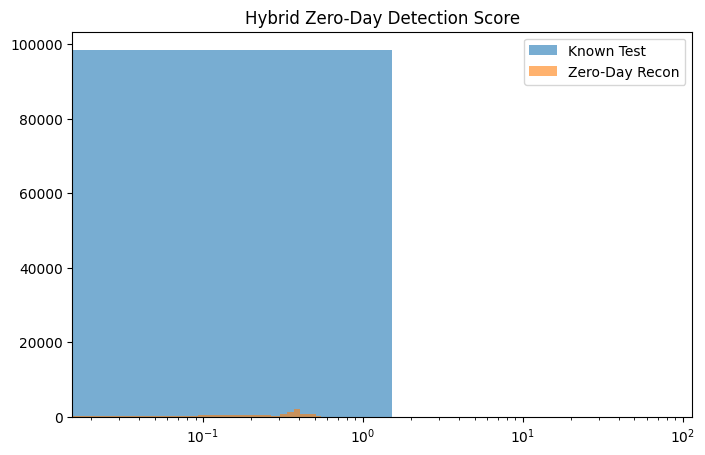

In [41]:
plt.figure(figsize=(8,5))
plt.hist(hybrid_known, bins=50, alpha=0.6, label="Known Test")
plt.hist(hybrid_zero, bins=50, alpha=0.6, label="Zero-Day Recon")
plt.xscale("log")
plt.legend()
plt.title("Hybrid Zero-Day Detection Score")
plt.show()

- AUC Scores for Zero-Day Detection

In [ ]:
# Labels: 0 = known, 1 = zero-day
y_true = np.concatenate([np.zeros_like(hybrid_known), np.ones_like(hybrid_zero)])
y_scores = np.concatenate([hybrid_known, hybrid_zero])

auc = roc_auc_score(y_true, y_scores)
print("Hybrid Zero-Day AUC:", auc)

Hybrid Zero-Day AUC: 0.7077302875867979


SHAP for Isolation Forest

In [ ]:
X_preview = pd.DataFrame(X_test_zero_day_scaled, columns=X_test_zero_day.columns)

In [ ]:
import shap

explainer_if = shap.TreeExplainer(iso)

shap_if_zero = explainer_if.shap_values(X_preview)
shap_if_zero.shape

(10491, 42)

SHAP summary plot for IF

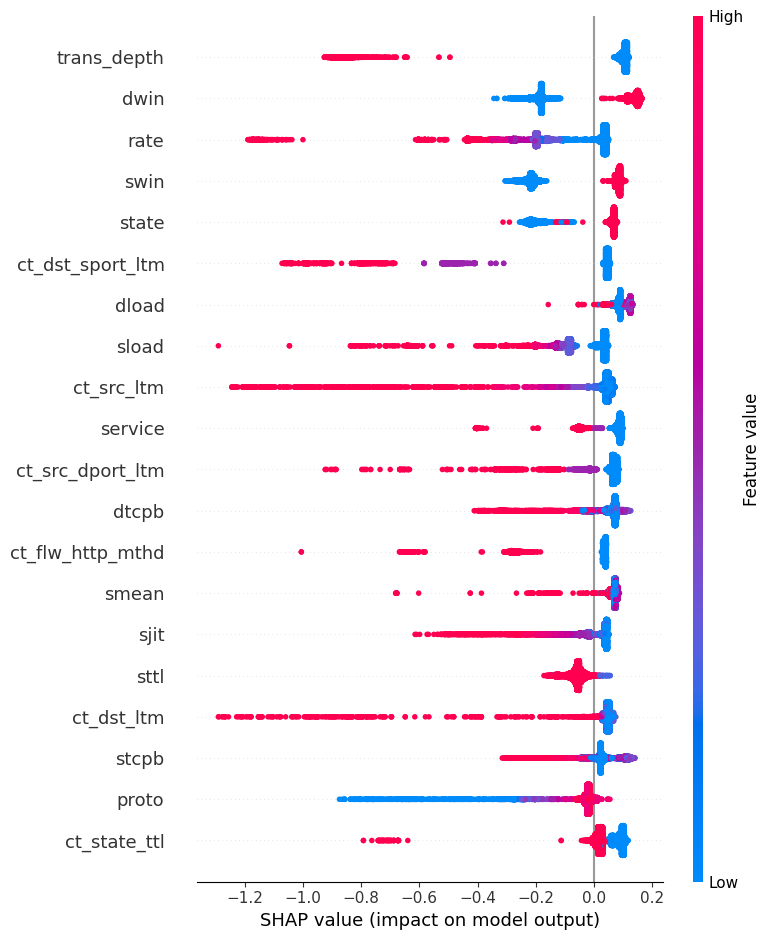

In [ ]:
shap.summary_plot(
    shap_if_zero,
    X_preview,
    feature_names=X_test_zero_day.columns,
    plot_type="dot",
    max_display=20
)

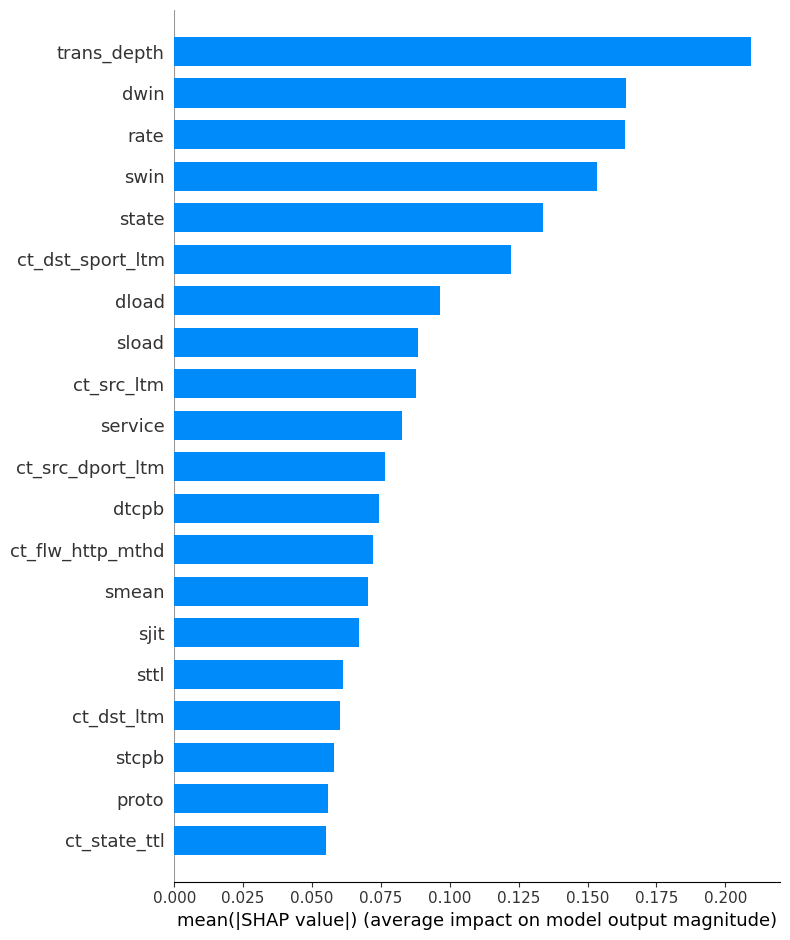

In [ ]:
# Bar plot
shap.summary_plot(
    shap_if_zero,
    X_preview,
    feature_names=X_test_zero_day.columns,
    plot_type="bar",
    max_display=20
)


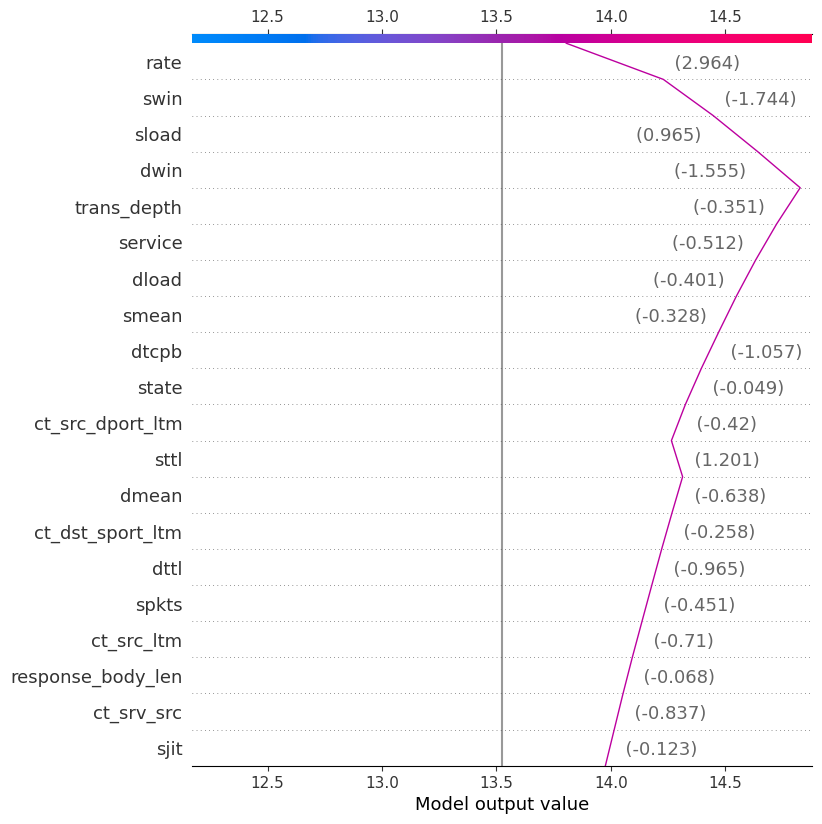

In [ ]:
index = 10
shap.decision_plot(
    explainer_if.expected_value,
    shap_if_zero[index, :],
    X_preview.iloc[index]
)

SHAP on autoencoder

In [ ]:
import tensorflow as tf
import shap

ae_background = X_train_normal_scaled[:200]

explainer_ae = shap.DeepExplainer(autoencoder, ae_background)

/usr/local/lib/python3.12/dist-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(200, 42))']
  warnings.warn(msg)


In [ ]:
# SHAP values of AE output for zero-day samples
shap_ae_zero = explainer_ae.shap_values(X_test_zero_day_scaled[:200])

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(400, 42))']
  warnings.warn(msg)


In [ ]:
# Calculate per-feature contribution to reconstruction error
recon_contrib = np.mean(np.abs(shap_ae_zero[0]), axis=0)

feature_importance_ae = pd.Series(
    recon_contrib,
    index=X_test_zero_day.columns
).sort_values(ascending=False)

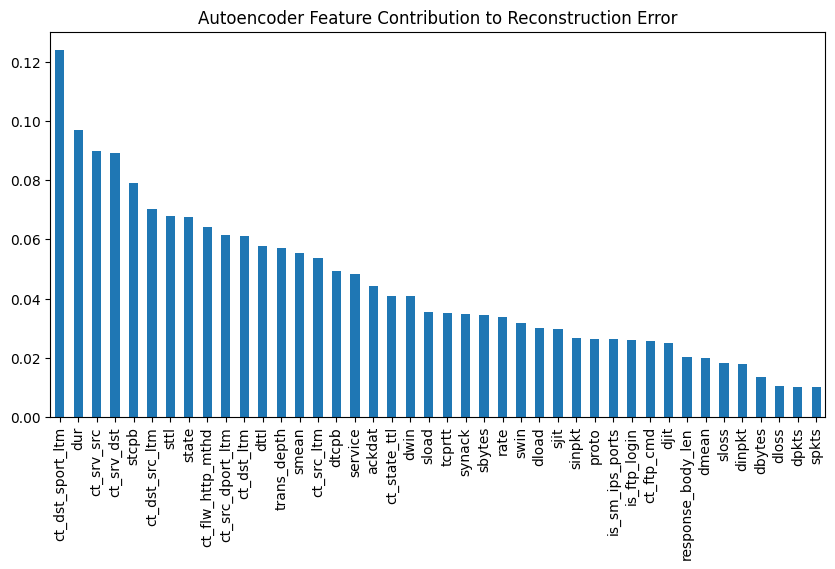

In [ ]:
feature_importance_ae.plot(kind="bar", figsize=(10,5), title="Autoencoder Feature Contribution to Reconstruction Error")
plt.show()

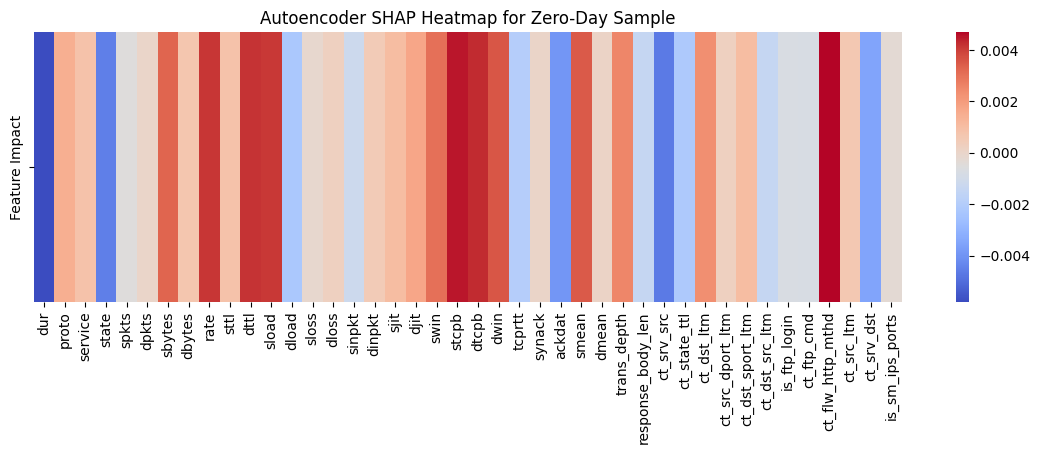

In [ ]:
import seaborn as sns

sample_index = 5

plt.figure(figsize=(14, 3.5))

sns.heatmap(
    shap_ae_zero[0][sample_index].reshape(1, -1),
    cmap="coolwarm",
    xticklabels=X_test_zero_day.columns,
    yticklabels=["Feature Impact"],
)
plt.title("Autoencoder SHAP Heatmap for Zero-Day Sample")
plt.show()

In [ ]:
# Save Models
joblib.dump(iso, "isolation_forest_zero_day.pkl")
autoencoder.save("autoencoder_zero_day.h5")
joblib.dump(scaler, "standardscaler_scaler.pkl")
joblib.dump(encoder, "label_encoder.pkl")

# Feature Names
import json
feature_list = list(X_train_normal.columns)
json.dump(feature_list, open("feature_names.json", "w"))